# CARGAR DATA SET

In [16]:
import math
import operator
import random

import matplotlib.pyplot as plt
import numpy as np
import sympy
from deap import algorithms, base, creator, gp, tools

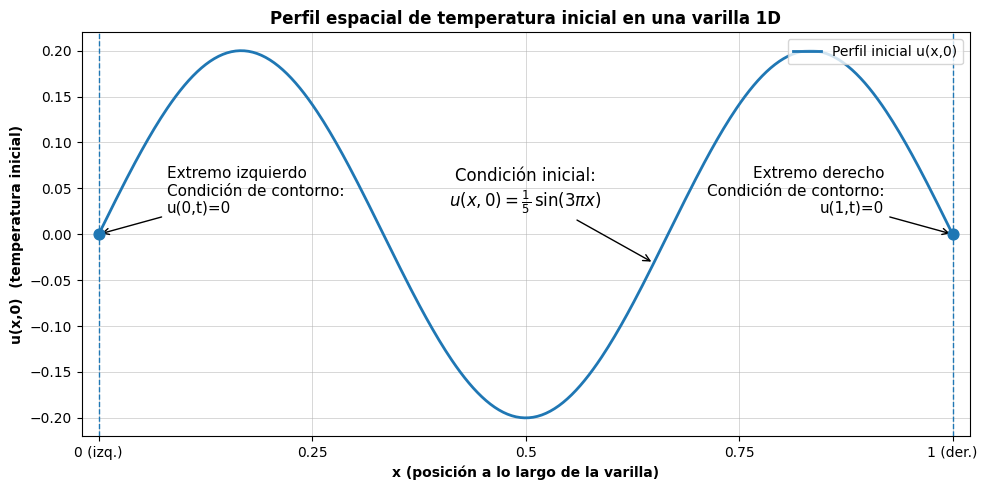

In [17]:
# Perfil inicial de temperatura en una varilla 1D con condiciones de contorno u(0,t)=0 y u(1,t)=0
n_puntos = 400

# Dominio espacial x en [0,1]
x = np.linspace(0.0, 1.0, n_puntos)

# Condición inicial: u(x,0) = (1/5) * sin(3πx)
u_inicial = (1/5) * np.sin(3*np.pi*x)




plt.figure(figsize=(10, 5))
plt.plot(x, u_inicial, linewidth=2, label="Perfil inicial u(x,0)")

plt.scatter([0,1], [0,0], s=60, zorder=5)
plt.annotate("Extremo izquierdo\nCondición de contorno:\nu(0,t)=0",
             xy=(0,0), xytext=(0.08, 0.02),
             arrowprops=dict(arrowstyle="->", lw=1),
             fontsize=11, ha="left", va="bottom")
plt.annotate("Extremo derecho\nCondición de contorno:\nu(1,t)=0",
             xy=(1,0), xytext=(0.92, 0.02),
             arrowprops=dict(arrowstyle="->", lw=1),
             fontsize=11, ha="right", va="bottom")

plt.annotate("Condición inicial:\n$u(x,0)=\\frac{1}{5}\\,\\sin(3\\pi x)$",
             xy=(0.65, (1/5)*np.sin(3*np.pi*0.65)), xytext=(0.5, .02),
             arrowprops=dict(arrowstyle="->", lw=1),
             fontsize=12, ha="center", va="bottom" )

plt.xlabel("x (posición a lo largo de la varilla)", fontweight="bold")
plt.ylabel("u(x,0)  (temperatura inicial)", fontweight="bold")
plt.title("Perfil espacial de temperatura inicial en una varilla 1D", fontweight="bold")

plt.xlim(-0.02, 1.02)
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ["0 (izq.)", "0.25", "0.5", "0.75", "1 (der.)"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.axvline(1, linestyle="--", linewidth=1)
plt.grid(True, linewidth=0.7, alpha=0.5)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


# FUNCIÓN OBJETIVO

In [18]:
def function(x):
    # A IMPLEMENTAR
    pass

# CONJUNTO DE PRIMITIVAS

In [19]:
primitive_set = gp.PrimitiveSet('MAIN', 1) # 1 variable de entrada
# SUMA
primitive_set.addPrimitive(operator.add, 2) 
# RESTA
primitive_set.addPrimitive(operator.sub, 2)
# MULTIPLICACION 
primitive_set.addPrimitive(operator.mul, 2) 
# NEGACION
primitive_set.addPrimitive(operator.neg, 1)    
# SENO
primitive_set.addPrimitive(math.sin, 1)    
# COSENO
primitive_set.addPrimitive(math.cos, 1)    
# Exponencial
#primitive_set.addPrimitive(math.exp, 1)
# PI 
primitive_set.addTerminal(math.pi, name="pi")
# CONSTANTES ALEATORIAS
primitive_set.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1)) # constantes aleatorias entre -1 y 1

# Renombrar variable de entrada
primitive_set.renameArguments(ARG0='x')

# DEFINIR EL TIPO DE FITNESS (minimizar el error)
try:
    creator.FitnessMin
except AttributeError:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
try:
    creator.Individual
except AttributeError:
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)



# FUNCION PARA INICIALIZAR INDIVIDUOS Y POBLACION
toolbox = base.Toolbox()

toolbox.register('expr', gp.genHalfAndHalf, pset=primitive_set , min_=1, max_=2) # Generar expresiones
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr) # Inicializar individuos
toolbox.register('population', tools.initRepeat, list, toolbox.individual) # Inicializar poblacion


# FUNCION PARA EVALUAR INDIVIDUOS
toolbox.register("compile", gp.compile, pset=primitive_set) # Compilar el individuo

# FUNCION DE EVALUACION 
# TODO: A implementar la funcion de evaluacion
data_points = x.copy()                 # malla espacial ya creada arriba
valores_objetivo = u_inicial.copy()    # u(x,0) = (1/5) sin(3πx)


def evaluar(individual):
    func = toolbox.compile(expr=individual)
    try:
        y_pred = np.array([func(xi) for xi in data_points], dtype=float)
        y_true = np.array(valores_objetivo, dtype=float)
        # cast agresivo para NaN/Inf: penaliza expresiones inválidas
        if not np.all(np.isfinite(y_pred)):
            return (1e9,)  # castigo grande si salen NaN/Inf
        mse = ((y_pred - y_true)**2).mean()
        # regulariza suavemente la complejidad: evita árboles monstruosos
        penalty = 1e-4 * len(individual)   # por qué: favorece parsimonia
        return (mse + penalty,)
    except Exception:
        return (1e9,)



# MECANISMOS EVOLUTIVOS
toolbox.register("evaluate", evaluar)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitive_set)


# SE LIMITA LA PROFUNDIDAD DE LOS INDIVIDUOS
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


# =================== ALGORITMO EVOLUTIVO ===================
poblacion = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)

# Estadisticas de la evolucion
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


# Algoritmo evolutivo simple parametros (poblacion=300, toolbox, crossover_prob=0.5, mutation_prob=0.05, generaciones=100, stats, hall_of_fame, verbose)
algorithms.eaSimple(poblacion, toolbox, 0.5, 0.05, 100, stats=stats, halloffame=hall_of_fame, verbose=True)



print("Mejor individuo: ", hall_of_fame[0])
print()



# =================== PARA MEJORAR LA VISUALIZACION DEL INDIVIDUO ===================
x = sympy.symbols('x')


replacements = {
    "add": lambda a,b: a + b,
    "sub": lambda a,b: a - b,
    "mul": lambda a,b: a * b,
    "neg": lambda a: -a,
    "sin": sympy.sin,
    "cos": sympy.cos,
    #"exp": sympy.exp,
    "pi": sympy.pi,
}


expr_str = str(hall_of_fame[0])
expr_sympy = sympy.sympify(expr_str, locals=replacements)

print(f"\nExpresión simbólica: {sympy.simplify(expr_sympy)}")

# Convertir el mejor individuo a una función de Python
func_mejor = toolbox.compile(expr=hall_of_fame[0])
print()



# Comparar con los valores originales
for x,y in zip(data_points, valores_objetivo):
    print(f"x={x:.2f} -> f(x)={y:.4f} | individuo(x)={func_mejor(x):.4f}")



gen	nevals	avg    	std    	min      	max  
0  	300   	4.71449	13.7783	0.0177385	117.1
1  	168   	1.58317	6.79792	0.0177385	100.228
2  	168   	5.62039	74.9426	0.0186585	1296.9 
3  	187   	4.9947 	74.7426	0.0183855	1296.9 
4  	160   	0.385789	1.77695	0.0183855	12.5621
5  	149   	0.481352	2.02063	0.0183855	10.156 
6  	156   	0.994673	8.07785	0.0183855	98.2651
7  	164   	0.293077	2.45625	0.0183855	38.9667
8  	170   	0.184988	2.25779	0.0183855	38.9667
9  	159   	0.0345703	0.0880071	0.0183855	0.960681
10 	154   	0.185553 	2.29425  	0.0183855	38.9667 
11 	155   	0.099065 	0.787085 	0.0183855	9.62367 
12 	152   	0.0385445	0.146527 	0.0183855	2.29164 
13 	164   	0.0615731	0.572774 	0.0183855	9.89232 
14 	168   	0.425289 	5.71253  	0.0183855	98.2651 
15 	176   	0.0672374	0.584714 	0.0182579	9.62367 
16 	163   	0.473578 	6.77976  	0.0182579	117.102 
17 	160   	0.149657 	1.34454  	0.0182579	19.7673 
18 	159   	0.152733 	1.03881  	0.0182579	10.1445 
19 	168   	0.765117 	7.90866  	0.0182579	96.5937 

/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


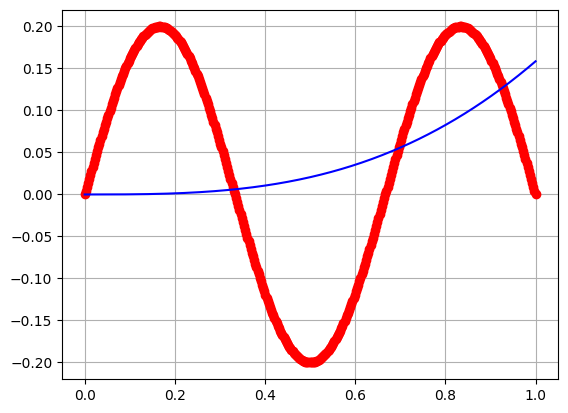

In [20]:

x = data_points
y = valores_objetivo


# Datos aproximados por el mejor individuo
y_aprox = [func_mejor(xi) for xi in x]


plt.plot(x,y,'ro')
plt.plot(x,y_aprox,'b-')
plt.grid()
plt.show()


